In [1]:
base_url = "D:/downloads"
image_path = "/jpeg/train"
import os
import pandas as pd
len(os.listdir(base_url + image_path))

33126

In [2]:
import csv
import numpy as np
with open(base_url + '/train.csv') as file_name:
    file_read = csv.reader(file_name)
    array = list(file_read)
    np_arr = np.array(array)
print(np_arr[1:,[0,-1]])

[['ISIC_2637011' '0']
 ['ISIC_0015719' '0']
 ['ISIC_0052212' '0']
 ...
 ['ISIC_9999515' '0']
 ['ISIC_9999666' '0']
 ['ISIC_9999806' '0']]


In [8]:
#read in train csv
train = pd.read_csv(base_url + '/train.csv')

#check for any missing values:
for col in train.columns:
    print(col + ' missing values: ' + str(train[col].isna().sum()))

#fill missing anatom site values with "unknown or other"
train.anatom_site_general_challenge.fillna('other or unknown', inplace=True)

#drop all rows from the train dataframe that are associated with 3 patients who are missing some data.
train.drop(train[(train['patient_id'] == 'IP_0550106') | (train['patient_id'] == 'IP_5205991') |(train['patient_id'] == 'IP_9835712')].index, inplace=True)

#check for any more missing values:
for col in train.columns:
    print(col + ' missing values: ' + str(train[col].isna().sum()))

data = train

n_pos = len(data[data['target']==1])
print('number of images in full train set: {}'.format(len(data)))
print('Number of positive images in subset of train set: {}'.format(n_pos))
print('Percentage of positive images in subset train set: {:.1%}'.format(n_pos/len(data)))
print('Number of negative images in subset train set: {}'.format(len(data) - n_pos))
print('Percentage of negative images in subset train set: {:.1%}'.format(1 - n_pos/len(data)))


image_name missing values: 0
patient_id missing values: 0
sex missing values: 65
age_approx missing values: 68
anatom_site_general_challenge missing values: 527
diagnosis missing values: 0
benign_malignant missing values: 0
target missing values: 0
image_name missing values: 0
patient_id missing values: 0
sex missing values: 0
age_approx missing values: 0
anatom_site_general_challenge missing values: 0
diagnosis missing values: 0
benign_malignant missing values: 0
target missing values: 0
number of images in full train set: 33058
Number of positive images in subset of train set: 584
Percentage of positive images in subset train set: 1.8%
Number of negative images in subset train set: 32474
Percentage of negative images in subset train set: 98.2%


In [9]:
malign_data = data[data['target']==1].to_numpy()[1:,[0,-1]]
benign_data = data[data['target']==0].to_numpy()
idx_x = np.random.choice(len(benign_data),int(len(benign_data)),replace=False)
benign_data = np.array(benign_data[idx_x])

benign_data = benign_data[:len(malign_data)+1]
benign_data = benign_data[1:,[0,-1]]
print(benign_data)
print(malign_data)
print(len(benign_data))
print(len(malign_data))


[['ISIC_4897895' 0]
 ['ISIC_4517595' 0]
 ['ISIC_6124436' 0]
 ...
 ['ISIC_2202665' 0]
 ['ISIC_0694033' 0]
 ['ISIC_8396474' 0]]
[['ISIC_0188432' 1]
 ['ISIC_0207268' 1]
 ['ISIC_0232101' 1]
 ...
 ['ISIC_9967383' 1]
 ['ISIC_9978107' 1]
 ['ISIC_9998682' 1]]
583
583


In [11]:
shuffle_benign = np.random.choice(len(benign_data),int(len(benign_data)),replace=False)
shuffle_malign = np.random.choice(len(malign_data),int(len(malign_data)),replace=False)
idx_train_benign = shuffle_benign[:int(len(shuffle_benign)*0.70)]
idx_test_benign = shuffle_benign[int(len(shuffle_benign)*0.70):int(len(shuffle_benign)*0.85)]
idx_valid_benign = shuffle_benign[int(len(shuffle_benign)*0.85):int(len(shuffle_benign)*1)]
idx_train_malign = shuffle_malign[:int(len(shuffle_malign)*0.70)]
idx_test_malign = shuffle_malign[int(len(shuffle_malign)*0.70):int(len(shuffle_benign)*0.85)]
idx_valid_malign = shuffle_malign[int(len(shuffle_malign)*0.85):int(len(shuffle_benign)*1)]

train_data_benign = benign_data[idx_train_benign]
test_data_benign = benign_data[idx_test_benign]
valid_data_benign = benign_data[idx_valid_benign]

train_data_malign = malign_data[idx_train_malign]
test_data_malign = malign_data[idx_test_malign]
valid_data_malign = malign_data[idx_valid_malign]
print(len(train_data_benign))
print(len(train_data_malign))
print(len(test_data_benign))
print(len(test_data_malign))

408
408
87
87


In [12]:
train_data = np.concatenate((train_data_benign, train_data_malign), axis=0)
test_data = np.concatenate((test_data_benign, test_data_malign), axis=0)
valid_data = np.concatenate((valid_data_benign, valid_data_malign), axis=0)

shuffle_train = np.random.choice(len(train_data),int(len(train_data)),replace=False)
shuffle_test = np.random.choice(len(test_data),int(len(test_data)),replace=False)
shuffle_valid = np.random.choice(len(valid_data),int(len(valid_data)),replace=False)

train_data = train_data[shuffle_train]
test_data = train_data[shuffle_test]
valid_data = train_data[shuffle_valid]
print(train_data)
print(test_data)
print(valid_data)

[['ISIC_5494411' 0]
 ['ISIC_8609756' 1]
 ['ISIC_7312977' 1]
 ...
 ['ISIC_8618266' 0]
 ['ISIC_6269166' 1]
 ['ISIC_1580767' 0]]
[['ISIC_7312977' 1]
 ['ISIC_8145348' 1]
 ['ISIC_2871230' 1]
 ['ISIC_6425888' 0]
 ['ISIC_7296130' 0]
 ['ISIC_6769965' 0]
 ['ISIC_7460887' 1]
 ['ISIC_4948093' 0]
 ['ISIC_1068686' 1]
 ['ISIC_1357175' 0]
 ['ISIC_3197069' 0]
 ['ISIC_4647349' 0]
 ['ISIC_2212473' 1]
 ['ISIC_4120174' 1]
 ['ISIC_5047840' 0]
 ['ISIC_5343231' 1]
 ['ISIC_5635940' 0]
 ['ISIC_3319229' 1]
 ['ISIC_0085902' 0]
 ['ISIC_7295035' 1]
 ['ISIC_4232761' 0]
 ['ISIC_9008844' 0]
 ['ISIC_5216586' 1]
 ['ISIC_5946099' 0]
 ['ISIC_5425721' 1]
 ['ISIC_0645454' 1]
 ['ISIC_8740695' 0]
 ['ISIC_7503950' 1]
 ['ISIC_5626108' 0]
 ['ISIC_6680634' 0]
 ['ISIC_1375476' 1]
 ['ISIC_3395787' 0]
 ['ISIC_6251753' 1]
 ['ISIC_3202724' 0]
 ['ISIC_6272249' 0]
 ['ISIC_3343475' 1]
 ['ISIC_8564474' 1]
 ['ISIC_3253484' 1]
 ['ISIC_6714082' 1]
 ['ISIC_6398283' 1]
 ['ISIC_5332107' 0]
 ['ISIC_8781451' 0]
 ['ISIC_9544832' 1]
 ['ISIC_458426

In [13]:
import cv2
import matplotlib.pyplot as plt

In [14]:
shapes = []
for img in train_data:
    shapes.append(np.shape(cv2.imread(base_url + image_path+ '/' + img[0] + '.jpg')))
print(shapes)

[(4000, 6000, 3), (2848, 4288, 3), (3456, 5184, 3), (1936, 2592, 3), (480, 640, 3), (4000, 6000, 3), (1936, 2592, 3), (1053, 1872, 3), (2448, 3264, 3), (4000, 6000, 3), (2448, 3264, 3), (480, 640, 3), (2448, 3264, 3), (4000, 6000, 3), (480, 640, 3), (2848, 4288, 3), (3456, 5184, 3), (1053, 1872, 3), (1053, 1872, 3), (1053, 1872, 3), (2448, 3264, 3), (2848, 4288, 3), (4000, 6000, 3), (2448, 3264, 3), (4000, 6000, 3), (480, 640, 3), (2848, 4288, 3), (2848, 4288, 3), (4000, 6000, 3), (2848, 4288, 3), (480, 640, 3), (480, 640, 3), (480, 640, 3), (3456, 5184, 3), (1053, 1872, 3), (2848, 4288, 3), (1053, 1872, 3), (4000, 6000, 3), (4000, 6000, 3), (2848, 4288, 3), (480, 640, 3), (4000, 6000, 3), (480, 640, 3), (4000, 6000, 3), (1053, 1872, 3), (1053, 1872, 3), (1053, 1872, 3), (4000, 6000, 3), (1053, 1872, 3), (3456, 5184, 3), (1053, 1872, 3), (2448, 3264, 3), (480, 640, 3), (1053, 1872, 3), (1053, 1872, 3), (3456, 5184, 3), (2448, 3264, 3), (3456, 5184, 3), (2448, 3264, 3), (3456, 5184, 3),

array([[<AxesSubplot: title={'center': '0'}>,
        <AxesSubplot: title={'center': '1'}>],
       [<AxesSubplot: title={'center': '2'}>, <AxesSubplot: >]],
      dtype=object)

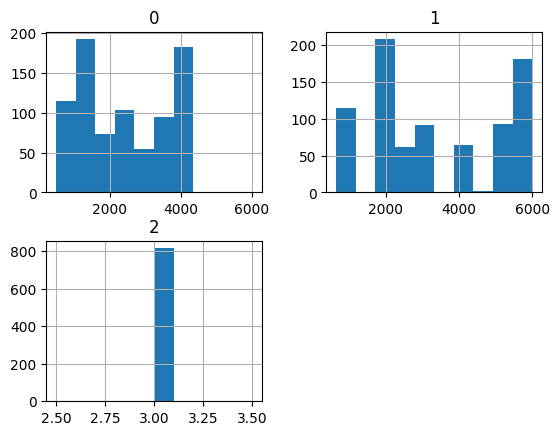

In [15]:
df = pd.DataFrame(data = shapes)
df.hist()

In [16]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(device_lib.list_local_devices())
print(tf.device('/device:GPU:0'))

Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2771721983063294281
xla_global_id: -1
]


In [17]:
import math

In [18]:
train_data[:,1]

array([0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,

In [31]:
class Generator(tf.keras.utils.Sequence ):

    def __init__(self, paths, labels, batch_size):
        self.paths, self.labels, self.batch_size = paths, labels, batch_size


    def __len__(self):
        return math.ceil(len(self.paths) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        

        batch_x = [self.hair_remove(cv2.resize(cv2.imread(base_url + image_path+ '/' + x + '.jpg'), (256 , 256 )).reshape((256,256,3))) for x in batch_x]
        batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=2)


    
        return np.array(batch_x), np.array(batch_y)
    def hair_remove(self, image):
    #convert image to greyscale
        grayScale = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
        #kernel for morphologyEx
        kernel = cv2.getStructuringElement(1,(17,17))
    
    #apply MORPH_Blackhat to grayscale image
        blackhat = cv2.morphologyEx(grayScale,cv2.MORPH_BLACKHAT,kernel)
    #apply thresholding to blackhat
        _, threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    #inpaint with original image and threshold image
        final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
    
        return final_image




train_gen = Generator(train_data[:,0], train_data[:,1], 4)
test_gen = Generator(test_data[:,0], test_data[:,1], 4)
valid_gen = Generator(valid_data[:,0], valid_data[:,1], 4)
print('done')
print(train_data[:,0])

done
['ISIC_5494411' 'ISIC_8609756' 'ISIC_7312977' 'ISIC_3253484'
 'ISIC_3319229' 'ISIC_3725269' 'ISIC_8417873' 'ISIC_2906486'
 'ISIC_4408559' 'ISIC_0085902' 'ISIC_4508878' 'ISIC_4992109'
 'ISIC_8509577' 'ISIC_2283063' 'ISIC_4221726' 'ISIC_8672524'
 'ISIC_3678730' 'ISIC_7076677' 'ISIC_1904244' 'ISIC_8781451'
 'ISIC_5581931' 'ISIC_0333091' 'ISIC_9764859' 'ISIC_8497457'
 'ISIC_4948093' 'ISIC_6613150' 'ISIC_8281208' 'ISIC_5140952'
 'ISIC_8679067' 'ISIC_4647349' 'ISIC_5905676' 'ISIC_4732353'
 'ISIC_8175453' 'ISIC_5216586' 'ISIC_3985031' 'ISIC_5425721'
 'ISIC_0946787' 'ISIC_9008844' 'ISIC_3197069' 'ISIC_9268487'
 'ISIC_7662847' 'ISIC_2751896' 'ISIC_3372750' 'ISIC_1988781'
 'ISIC_0701455' 'ISIC_4232761' 'ISIC_4954282' 'ISIC_6352565'
 'ISIC_4523238' 'ISIC_2565206' 'ISIC_5635940' 'ISIC_4000481'
 'ISIC_8027899' 'ISIC_5600499' 'ISIC_3909039' 'ISIC_4947726'
 'ISIC_5332107' 'ISIC_9038318' 'ISIC_6398669' 'ISIC_3517311'
 'ISIC_6398283' 'ISIC_8740695' 'ISIC_7601418' 'ISIC_0230169'
 'ISIC_0645454' 'IS

In [33]:
from tensorflow.keras import layers, models

In [34]:
resnet_model = models.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(254, activation='relu'))
resnet_model.add(layers.Dense(128, activation='relu'))
resnet_model.add(layers.Dense(2, activation='softmax'))


In [35]:
resnet_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

# tf.keras.utils.plot_model(resnet_model)
print('done')

done


In [37]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="first/future.hdf5",
        #     save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

In [38]:
history = resnet_model.fit(train_gen, validation_data=test_gen, epochs=10, callbacks=[model_checkpoint_callback])
print('done')

c:\Users\User\.virtualenvs\backend-XsqvQ-Tn\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


  7/204 [>.............................] - ETA: 3:24 - loss: 1.0475 - accuracy: 0.6429

KeyboardInterrupt: 